<a href="https://colab.research.google.com/github/anggaangoro3/Outlier-Detection-Using-PCA-DBSCAN/blob/main/anomaly_detection_using_DBSCAN_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Smartwatch Health Data - Clustering & Anomaly Detection
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns

# Load Dataset
file_path = '/content/drive/MyDrive/datasource/unclean_smartwatch_health_data.csv'
df = pd.read_csv(file_path)

# --- Basic Checks ---
print(df.isnull().sum())
df.info()

User ID                   201
Heart Rate (BPM)          400
Blood Oxygen Level (%)    300
Step Count                100
Sleep Duration (hours)    150
Activity Level            200
Stress Level              200
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   User ID                 9799 non-null   float64
 1   Heart Rate (BPM)        9600 non-null   float64
 2   Blood Oxygen Level (%)  9700 non-null   float64
 3   Step Count              9900 non-null   float64
 4   Sleep Duration (hours)  9850 non-null   object 
 5   Activity Level          9800 non-null   object 
 6   Stress Level            9800 non-null   object 
dtypes: float64(4), object(3)
memory usage: 547.0+ KB


In [ ]:
df.head()

,User ID,Heart Rate (BPM),Blood Oxygen Level (%),Step Count,Sleep Duration (hours),Activity Level,Stress Level
0,4174.0,58.939776,98.809650,5450.390578,7.167235622316564,Highly Active,1
1,NaN,NaN,98.532195,727.601610,6.538239375570314,Highly_Active,5
2,1860.0,247.803052,97.052954,2826.521994,ERROR,Highly Active,5
3,2294.0,40.000000,96.894213,13797.338044,7.367789630207228,Actve,3
4,2130.0,61.950165,98.583797,15679.067648,NaN,Highly_Active,6


In [ ]:
# Drop Duplicate Rows
df = df.drop_duplicates()

# Handle Wrong Entries / Error Values

# Fix 'Sleep Duration (hours)' entries ('ERROR' to NaN)
df['Sleep Duration (hours)'] = pd.to_numeric(df['Sleep Duration (hours)'], errors='coerce')


# Fix invalid 'Stress Level' entries (e.g., 'Very High')
def fix_stress(val):
    try:
        return int(val)
    except:
        return np.nan

df['Stress Level'] = df['Stress Level'].apply(fix_stress)

# Convert 'Activity Level' to numerical
activity_mapping = {
    'Seddentary': 0,
    'Sedentary': 0,
    'Actve': 1,
    'Active': 1,
    'Highly Active': 2,
    'Highly_Active': 2
}

# Apply the mapping
df['Activity Level'] = df['Activity Level'].replace(activity_mapping)

# Ensure the column is of a numeric type, coercing any non-numeric values to NaN
df['Activity Level'] = pd.to_numeric(df['Activity Level'], errors='coerce')

# Impute Missing Values
# Numeric columns: fill missing with mean
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# Categorical columns: fill missing with mode
# After numerical conversion of 'Activity Level', only truly categorical columns should remain here.
cat_cols = df.select_dtypes(include=['object']).columns
if not cat_cols.empty:
    df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

# Drop 'User ID'
df = df.drop('User ID', axis=1)

# Feature Selection ---
selected_features = [
    'Heart Rate (BPM)',
    'Blood Oxygen Level (%)',
    'Step Count',
    'Sleep Duration (hours)',
    'Stress Level',
    'Activity Level' # Add Activity Level to selected features
]

X = df[selected_features]
# X_scaled is ready for clustering or anomaly detection!


/tmp/ipython-input-1630474865.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Activity Level'] = df['Activity Level'].replace(activity_mapping)


In [ ]:
df.head()

,Heart Rate (BPM),Blood Oxygen Level (%),Step Count,Sleep Duration (hours),Activity Level,Stress Level
0,58.939776,98.809650,5450.390578,7.167236,2.0,1.0
1,76.035462,98.532195,727.601610,6.538239,2.0,5.0
2,247.803052,97.052954,2826.521994,6.505463,2.0,5.0
3,40.000000,96.894213,13797.338044,7.367790,1.0,3.0
4,61.950165,98.583797,15679.067648,6.505463,2.0,6.0


In [ ]:
df.isnull().sum()

,0
Heart Rate (BPM),0
Blood Oxygen Level (%),0
Step Count,0
Sleep Duration (hours),0
Activity Level,0
Stress Level,0


In [ ]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Final feature set:\n", selected_features)
print("Shape of preprocessed data:", X_scaled.shape)


Final feature set:
 ['Heart Rate (BPM)', 'Blood Oxygen Level (%)', 'Step Count', 'Sleep Duration (hours)', 'Stress Level', 'Activity Level']
Shape of preprocessed data: (10000, 6)


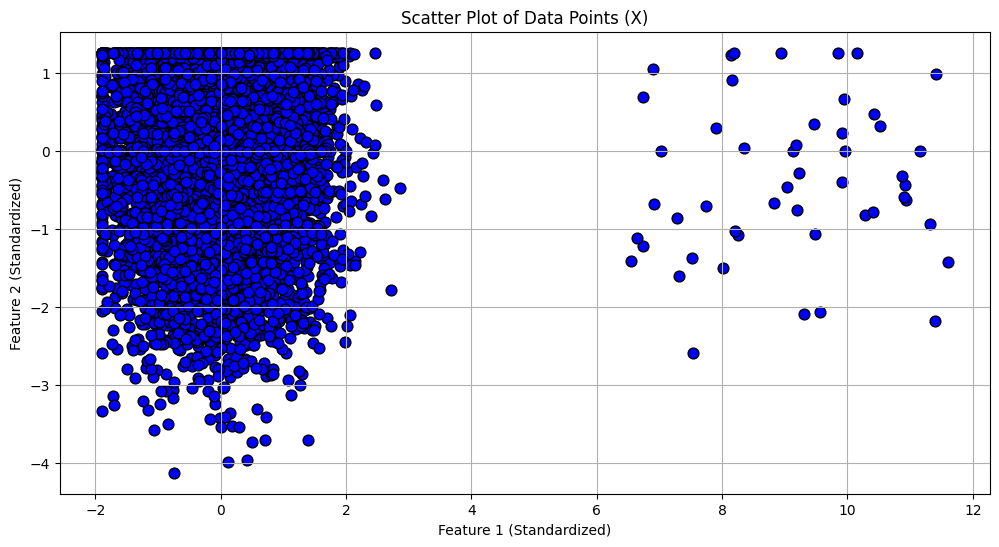

In [ ]:
# Scatter Plot of Raw Data
plt.figure(figsize=(12, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c='blue', edgecolor='k', s=60)
plt.title("Scatter Plot of Data Points (X)")
plt.xlabel("Feature 1 (Standardized)")
plt.ylabel("Feature 2 (Standardized)")
plt.grid(True)

plt.show()

In [ ]:
# PCA for Visualization 3D
pca_vis = PCA(n_components=3)
X_pca_vis = pca_vis.fit_transform(X_scaled)

Pembahasan pada DBSCAN akan di fokuskan ke epsilon dan minimal sample

/tmp/ipython-input-356018894.py:18: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_scaled[labels == label, 0], X_scaled[labels == label, 1],


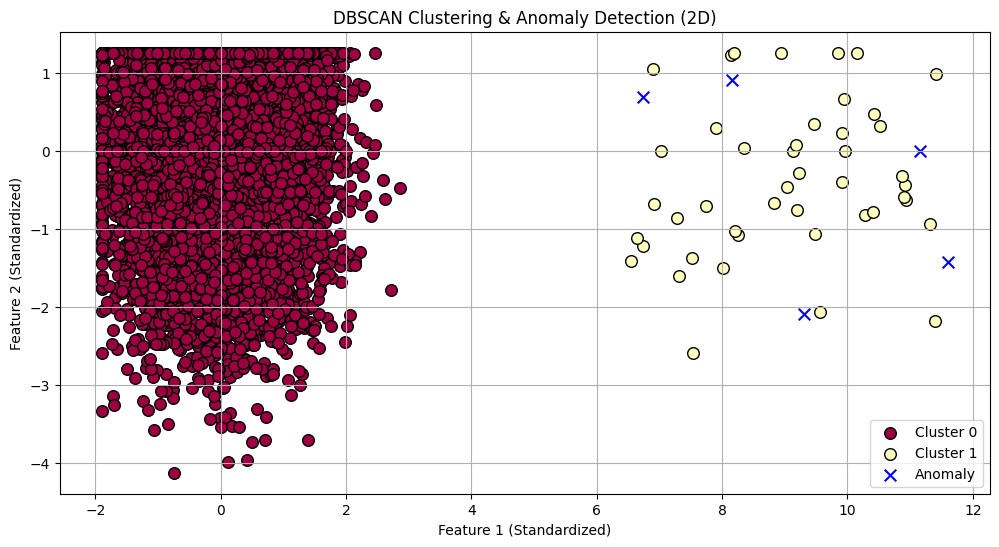

Jumlah anomali yang terdeteksi oleh DBSCAN: 5


In [ ]:
# DBSCAN Clustering
dbscan = DBSCAN(eps=2.7, min_samples=9)
labels = dbscan.fit_predict(X_scaled)

# Plot DBSCAN Results 2D
plt.figure(figsize=(12, 6))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for label, col in zip(unique_labels, colors):
    if label == -1:
        col = 'blue'
        marker = 'x'
        label_name = 'Anomaly'
    else:
        marker = 'o'
        label_name = f'Cluster {label}'
    plt.scatter(X_scaled[labels == label, 0], X_scaled[labels == label, 1],
                c=[col], marker=marker, label=label_name, edgecolors='black', s=70)

plt.title("DBSCAN Clustering & Anomaly Detection (2D)")
plt.xlabel("Feature 1 (Standardized)")
plt.ylabel("Feature 2 (Standardized)")
plt.legend()
plt.grid(True)
plt.show()

# Hitung jumlah anomali
num_anomalies = sum(labels == -1)

# Cetak hasil jumlah anomali
print(f"Jumlah anomali yang terdeteksi oleh DBSCAN: {num_anomalies}")

In [ ]:
# 3D Visualization for DBSCAN with Plotly
fig_dbscan = px.scatter_3d(
    x=X_pca_vis[:, 0], y=X_pca_vis[:, 1], z=X_pca_vis[:, 2],
    color=labels.astype(str),
    labels={"x": "PC1", "y": "PC2", "z": "PC3"},
    title="DBSCAN Clustering & Anomaly Detection (3D Plotly)",
)

# Ubah warna cluster dan anomali
fig_dbscan.update_traces(
    selector=dict(name='0'),
    marker=dict(color='red', size=4)
)
fig_dbscan.update_traces(
    selector=dict(name='1'),
    marker=dict(color='orange', size=4)
)
fig_dbscan.update_traces(
    selector=dict(name='2'),
    marker=dict(color='green', size=4)
)
fig_dbscan.update_traces(
    selector=dict(name='-1'),  # Anomali
    marker=dict(color='blue', symbol='x', size=4)
)
fig_dbscan.show()

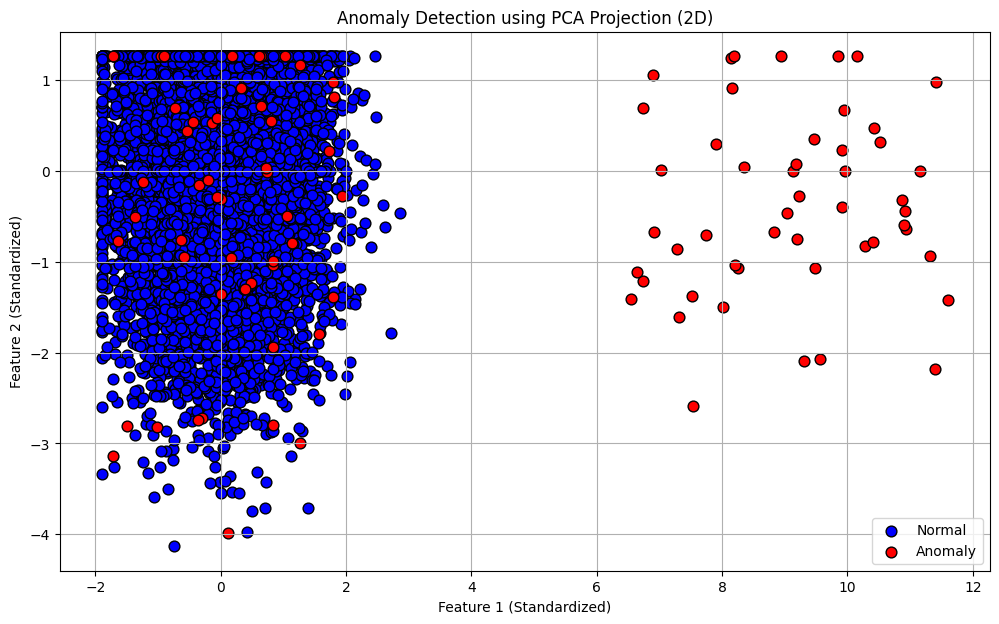

Jumlah anomali yang terdeteksi oleh PCA: 100


In [ ]:
# PCA for Anomaly Detection
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

anomaly_scores = np.linalg.norm(X_pca, axis=1)
threshold = np.percentile(anomaly_scores, 99)
y_pred_pca = anomaly_scores < threshold

# Plot PCA Anomaly Detection 2D
plt.figure(figsize=(12, 7))
plt.scatter(X_scaled[y_pred_pca, 0], X_scaled[y_pred_pca, 1],
            c='blue', label='Normal', edgecolor='k', s=60)
plt.scatter(X_scaled[~y_pred_pca, 0], X_scaled[~y_pred_pca, 1],
            c='red', label='Anomaly', edgecolor='k', s=60)
plt.title("Anomaly Detection using PCA Projection (2D)")
plt.xlabel("Feature 1 (Standardized)")
plt.ylabel("Feature 2 (Standardized)")
plt.legend()
plt.grid(True)
plt.show()

# Hitung jumlah anomali
num_anomalies_pca = sum(~y_pred_pca)

# Cetak hasil jumlah anomali
print(f"Jumlah anomali yang terdeteksi oleh PCA: {num_anomalies_pca}")

In [ ]:
# 3D Visualization for PCA Anomaly Detection with Plotly
# Create a DataFrame for Plotly Express
df_pca = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'PC3': X_pca[:, 2],
    'Anomaly': np.where(y_pred_pca, 'Normal', 'Anomaly')  # Add the 'Anomaly' column
})

fig_pca = px.scatter_3d(
    df_pca,  # Pass the DataFrame here
    x='PC1',
    y='PC2',
    z='PC3',
    color='Anomaly',  # Use the 'Anomaly' column for color
    labels={"x": "PC1", "y": "PC2", "z": "PC3"},
    title="Anomaly Detection using PCA Projection (3D Plotly)",
)

fig_pca.update_traces(marker_size=4, selector=dict(name='Normal'))
fig_pca.update_traces(marker_size=4, selector=dict(name='Anomaly'))

# Ubah warna cluster dan anomali (Adjust colors if needed)
fig_pca.show()